<a href="https://colab.research.google.com/github/Shankar1920/FMML-22B21A4556/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-15 03:27:52--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.4.25, 13.225.4.109, 13.225.4.31, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.4.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   100MB/s    in 0.5s    

2024-05-15 03:27:53 (100 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


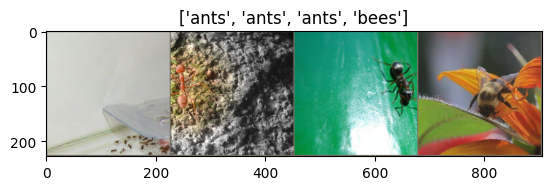

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5851 Acc: 0.7172

Epoch 1/4
----------
Loss: 0.3565 Acc: 0.8443

Epoch 2/4
----------
Loss: 0.5249 Acc: 0.7992

Epoch 3/4
----------
Loss: 0.4399 Acc: 0.7951

Epoch 4/4
----------
Loss: 0.4435 Acc: 0.8074



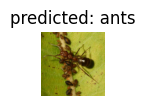

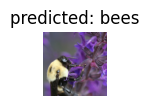

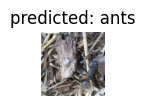

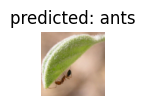

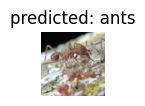

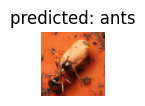

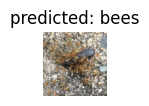

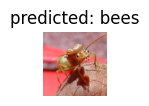

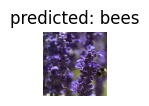

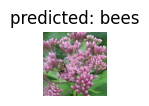

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


**1st ANSWER**

The significance of using data augmentations such as resizing, cropping, and other transformations on training data can be summarized as follows:

1. **Increased Robustness and Generalization**:
   - Data augmentations introduce variations in the training data, making the model more robust to different input variations that might be encountered during inference. For example, resizing and cropping simulate different scales and aspect ratios of objects in images, which helps the model learn to recognize objects under various conditions.
   
2. **Regularization**:
   - Data augmentations act as a form of regularization by adding noise or variations to the training samples. This can prevent overfitting by exposing the model to a wider range of scenarios and reducing its reliance on specific details or patterns present in the original training data.
   
3. **Improved Performance on Test Data**:
   - When training data is augmented, the resulting model is often more effective when applied to real-world test data. This is because the model has learned to generalize better from the augmented training samples, which are more representative of the variability in real-world data.
   
4. **Handling Invariance**:
   - Data augmentations help in learning features that are invariant to certain transformations. For instance, if the model needs to recognize objects irrespective of their orientation or position in an image, augmentations like rotation and translation can aid in learning these invariant features.
   
5. **Enhanced Dataset Size**:
   - By applying augmentations, the effective size of the training dataset can be increased without collecting additional labeled samples. This is particularly beneficial when working with limited data, as it allows the model to learn from a more diverse set of examples.
   
6. **Mitigating Data Imbalance**:
   - Augmentations can be used to balance class distributions within the training data. For example, by generating synthetic samples for underrepresented classes through transformations, the model can be trained more effectively to recognize these classes.
   
7. **Adaptation to Real-world Variations**:
   - In many real-world applications, the input data can vary significantly due to factors like lighting conditions, camera perspectives, or object positions. Data augmentations simulate these variations during training, enabling the model to handle such real-world scenarios more adeptly.
   
In summary, data augmentations play a crucial role in enhancing the performance, robustness, and generalization capabilities of machine learning models by exposing them to diverse variations and conditions during training. By leveraging data augmentations effectively, models can achieve better performance and reliability when deployed in practical applications.

**2ND ANSWER**

If you choose not to use a pre-trained ResNet model (by setting `pretrained=False`) and instead train the ResNet model from scratch on your specific dataset, the performance of the model might be affected in several ways:

1. **Effect on Training Time**:
   Training a deep neural network like ResNet from scratch can significantly increase training time compared to using a pre-trained model. Pre-trained models leverage weights learned from large datasets like ImageNet, which provides a good starting point for training on other datasets.

2. **Need for Larger Dataset**:
   Training from scratch often requires a larger and more diverse dataset to learn meaningful representations and features. Pre-trained models already possess learned features that are transferable and generalize well to new tasks or datasets.

3. **Risk of Overfitting**:
   Without pre-training, the model starts with random initialization of weights. This can lead to faster overfitting, especially when the dataset is small or lacks diversity. Regularization techniques like dropout and weight decay may be required to prevent overfitting.

4. **Potential Lower Performance**:
   Pre-trained models capture generic features that are useful across a wide range of tasks. Training without pre-training may result in a model that does not generalize as well or achieves lower performance on tasks where large-scale pre-training is beneficial.

5. **Dependency on Initialization**:
   The performance of a model trained from scratch can be sensitive to the choice of initialization and training hyperparameters. Experimentation with different initializations and training strategies might be necessary to achieve optimal results.

6. **Lack of Transfer Learning Benefits**:
   Pre-trained models offer transfer learning benefits, where knowledge gained from pre-training can be transferred to new tasks. Training from scratch may require more task-specific tuning and may not leverage previous learnings effectively.

To assess the performance when training a ResNet model from scratch (`pretrained=False`), you would typically follow these steps:

- **Define the Model**: Instantiate the ResNet model architecture with `pretrained=False`.
- **Prepare the Dataset**: Organize your dataset into training, validation, and possibly test sets.
- **Choose Optimizer and Loss Function**: Select an optimizer (e.g., SGD, Adam) and a suitable loss function (e.g., CrossEntropyLoss) for your task.
- **Train the Model**: Train the ResNet model on the training data, monitoring performance on the validation set to adjust hyperparameters and prevent overfitting.
- **Evaluate Performance**: Evaluate the trained model on a held-out test set to assess its performance in terms of accuracy, precision, recall, etc.

Comparing the performance of a model trained from scratch versus a pre-trained model can provide insights into the effectiveness of transfer learning and the suitability of the chosen approach for your specific task and dataset. Adjustments to training strategies, data augmentation, and regularization techniques may be required to achieve optimal performance when training from scratch.

**3RD ANSWER**

The performance of a pre-trained ResNet model on a new dataset (such as the ants vs bees dataset) depends on several factors, including the similarity between the pre-training dataset and the target dataset. Here are key considerations:

1. **Feature Transferability**:
   - Pre-trained models like ResNet, trained on large and diverse datasets like ImageNet, learn general features that are transferable across different tasks and datasets. Lower-level features (e.g., edges, textures) are often shared among different visual recognition tasks.
   - However, if the target dataset (ants vs bees) contains significantly different types of images (e.g., different subjects, backgrounds, lighting conditions), the learned features from the pre-trained model may not directly translate well to the new dataset.

2. **Fine-Tuning vs. Feature Extraction**:
   - Fine-tuning a pre-trained model involves updating the weights of the model's final layers (e.g., fully connected layers) on the new dataset while keeping the convolutional base frozen or partially frozen.
   - Alternatively, feature extraction involves using the pre-trained model as a fixed feature extractor, where the output features from the convolutional base are used as input to a new classifier trained specifically for the target dataset.
   - Fine-tuning is more effective when the pre-training dataset is similar to the target dataset. In contrast, feature extraction can be beneficial when the datasets are dissimilar.

3. **Domain Shift**:
   - If the domain shift between the pre-training dataset (e.g., ImageNet) and the target dataset (ants vs bees) is significant (e.g., different species, environments), the effectiveness of the pre-trained model may be limited.
   - Domain adaptation techniques may be required to bridge the gap between the source domain (pre-training dataset) and the target domain (target dataset) to achieve better performance.

4. **Evaluation and Adjustment**:
   - It's essential to evaluate the performance of the pre-trained model on the target dataset through validation and testing. Monitor metrics like accuracy, precision, recall, and analyze the model's behavior on specific classes (ants vs bees).
   - Depending on the observed performance, adjustments such as fine-tuning, adjusting learning rates, incorporating additional data augmentation, or training from scratch may be necessary.

In summary, while pre-trained models offer valuable features and representations learned from large-scale datasets, their performance on a new dataset like ants vs bees can vary based on dataset characteristics, domain differences, and task complexity. Experimentation and adaptation techniques are key to optimizing the use of pre-trained models for specific tasks and datasets.